In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la
import math as math

from funicular import *

# Helper Functions

In [2]:
'''
RETURN INTERSECTION OF TWO LINES IN POINT-SLOPE FORM
p = points (x, y)
m = slopes
'''
def get_intersect(p1, m1, p2, m2):
    if abs(m1) == np.inf and abs(m2) == np.inf:
        return (p1[0], np.inf)
    
    # If one of them is a vertical line
    if abs(m2) == np.inf:
        temp_p = p1
        temp_m = m1
        p1 = p2
        m1 = m2
        p2 = temp_p
        m2 = temp_m
    if abs(m1) == np.inf:
        x = p1[0]
        y = m2*(x-p2[0]) + p2[1]
        return (x, y)
    
    
    b = np.array([m1*-p1[0] + p1[1], m2*-p2[0] + p2[1]])
    B = np.array(b).reshape(2, 1)
    A = np.array([[-m1, 1], [-m2, 1]])
    X = la.solve(A, B)

    return (X[0][0], X[1][0])


def create_Pratt(span, panels, height):
    nodes = []
    for x in np.arange(0, span+span/panels, span/panels):
        for y in [0, height]:
            nodes.append([x, y])
    nodes = np.array(nodes)

    members = []
    for i in range(int(panels/2)):
        # Vertical member
        members.append([2*i, 2*i+1])

        # Horizontal chords
        members.append([2*i, 2*i+2])
        members.append([2*i+1, 2*i+3])

        # Diagonal member
        members.append([2*i+1, 2*i+2])

    i = int(panels/2)
    members.append([2*i, 2*i+1])  

    for i in range(int(panels/2), panels):
        # Horizontal member
        members.append([2*i, 2*i+2])
        members.append([2*i+1, 2*i+3])

        # Vertical member
        members.append([2*i+2, 2*i+3])

        # Diagonal member
        members.append([2*i, 2*i+3])
    members = np.array(members)
    
    return nodes, members

# Truss Class

In [49]:
class Truss:
    # Geometry
    nodes = []
    members = []
    slopes = []
    
    # Boundary Forces
    forces = []
    force_node = []
    supports = []
    
    # Connectivity between members, nodes, and forces
        # spaces = force diagram coordinates of each space
    spaces = []
        # connectivity = force indices associated with each node
    connectivity = []
        # node_forces = dict for each node that carries its force with the spaces it divides going CCW
    node_forces = []
        # force_space = condensed version of node_forces that relates forces to the spaces it divides
    force_space = []
    
    ''' CONSTRUCTOR '''
    def __init__(self, nodes, members):
        self.nodes = nodes
        self.members = members
        
        # Slopes of each member
        s = members[:, 0]
        e = members[:, 1]

        dx = nodes[e, 0] - nodes[s, 0]
        dy = nodes[e, 1] - nodes[s, 1]

        slopes = np.zeros(len(dx))
        slopes[dx==0] = np.inf
        slopes[dx!=0] = dy[dx!=0]/dx[dx!=0]
        self.slopes = slopes
     
    '''
    SET LOADS ON THE TRUSS
    forces = array of foce magnitudes (vertical)
    force_node = nodes forces are applied to
    supports = nodes that are fixed (vertical)
    '''
    def set_loads(self, forces, force_node, supports):
        self.forces = forces
        self.force_node = force_node
        self.supports = supports
        
        # reset arrays 
        spaces = []
        connectivity = []
        node_forces = []
        force_space = []
        
        # recalibrate the force-space
        #self.get_connectivity()
        #self.init_force_space()
    
    
    ''' CREATE CONNECTIVITY ARRAY FOR EACH NODE '''
    def get_connectivity(self):
        nf = len(self.forces)
        
        connectivity = []
        for n in range(self.nodes.shape[0]):
            mems = np.where(self.members==n)[0]+nf
            connectivity.append(mems)

        for i in range(len(self.force_node)):
            connectivity[self.force_node[i]] = np.append(connectivity[self.force_node[i]], i)


        #  Reorder nodes so that they go clockwise
        Angles = []
        for n, mems in enumerate(connectivity):
            angs = np.array([])
            for m in mems:
                # Calculate applied force orientation
                if m < nf:
                    if self.forces[m] > 0: ang = 3*math.pi/2
                    else: ang = math.pi/2

                # Calculate member orientation
                else:
                    s = self.nodes[n]

                    if np.where(self.members[m-nf]==n)[0][0] == 1:
                        e = nodes[self.members[m-nf, 0]]
                    else:
                        e = nodes[self.members[m-nf, 1]]

                    # Calculate inverse sin of the member
                    dx = e[0]-s[0]
                    dy = e[1]-s[1]
                    d = (dx**2+dy**2)**0.5
                    ang = math.asin(dy/d)

                    # Adjust based on limits of sin
                    if dx < 0:
                        if dy < 0:
                            ang = math.pi + abs(ang)
                        else:
                            ang = math.pi - ang
                    elif dy < 0:
                        ang = 2*math.pi + ang

                angs = np.append(angs, ang)

            # Reorder members by increasing angle (counter clockwise)
            connectivity[n] = connectivity[n][np.argsort(angs)]
        
        self.connectivity = connectivity
    
    
    def init_force_space(self):
        
        # Track panels/spaces assigned to each force
        forces = []
        nf = len(self.forces)

        # Input every forces for every node
        for n in range(self.nodes.shape[0]):
            forces.append({})
            for c in self.connectivity[n]:
                forces[n][c]=[-1, -1]

        # For each external force, assign the spaces
        for i in range(nf):
            n = self.force_node[i]
            conn = self.connectivity[n]

            # Assign spaces based on external force
            forces[n][i] = [(i+1)%nf, i]

            # Update adjacent members to share the space
            for j, c in enumerate(conn):

                if forces[n][c][0] != -1:
                    c2 = conn[(j-1)%len(conn)]

                    if c2-nf >= 0:
                        forces[n][c2][1] = forces[n][c][0]

                        # Update space for the other node the member is attached to
                        n2 = self.members[c2-nf, np.where(self.members[c2-nf]!=n)[0][0]]
                        forces[n2][c2][0] = forces[n][c][0]

                if forces[n][c][1] != -1:
                    c2 = conn[(j+1)%len(conn)]

                    if c2-nf>=0:
                        forces[n][c2][0] = forces[n][c][1] 

                        # Update space for the other node the member is attached to
                        n2 = self.members[c2-nf, np.where(self.members[c2-nf]!=n)[0][0]]
                        forces[n2][c2][1] = forces[n][c][1]
        
        self.force_space = forces
        
        
    def find_spaces(self):
        nf = len(self.forces)
        
        # Initialize spaces vector with the locations of the external force spaces
        spaces = np.zeros((nf, 2))
        spaces[1:, 1] = self.forces[0:-1]
        spaces = np.cumsum(spaces, axis=0)

        # Queue of nodes to look at 
        queue = list(range(self.nodes.shape[0]))

        ''' SOLVE FOR UNKNOWN SPACE NODE BY NODE'''
        while len(queue) > 0:
            

            # get next node
            n = queue.pop(0)

            # Check if there is only 1 degree of freedom (2 -1's in the force dict)
            dof_count = 0
            for i, mem in enumerate(self.force_space[n]):
                for dof in self.force_space[n][mem]:
                    if dof == -1:
                        dof_count += 1
            
            
            # Add add node to end of queue if it is not solveable yet
            if dof_count > 2:
                queue.append(n)

            # if the current node is solveable
            elif dof_count == 2:

                # Next numbering of space
                snum = spaces.shape[0]

                # Get two spaces to solve for and the corresponding member slopes
                s1 = -1
                m1 = 0
                f1 = -1
                s2 = -1
                m2 = 0
                f2 = -1
                for i, mem in enumerate(self.force_space[n]):
                    if self.force_space[n][mem][0] == -1:
                        s1 = self.force_space[n][mem][1]
                        m1 = self.slopes[mem-nf]
                        f1 = mem

                    if self.force_space[n][mem][1] == -1:
                        s2 = self.force_space[n][mem][0]
                        m2 = self.slopes[mem-nf]
                        f2 = mem

                # find intersection of these two force lines and add it to spaces
                spaces = np.append(spaces, [get_intersect(spaces[s1], m1, spaces[s2], m2)], axis=0)


                # Update force to new unknown space
                self.force_space[n][f1][0]=snum
                self.force_space[n][f2][1]=snum

                # update forces with new known force
                n1 = self.members[f1-nf, np.where(self.members[f1-nf]!=n)[0][0]]
                self.force_space[n1][f1][1]=snum
                n2 = self.members[f2-nf, np.where(self.members[f2-nf]!=n)[0][0]]
                self.force_space[n2][f2][0]=snum

                # update adjacent forces
                conn1 = self.connectivity[n1]
                i1 = np.where(conn1==f1)[0][0]
                self.force_space[n1][conn1[(i1+1)%len(conn1)]][0] = snum
                conn2 = self.connectivity[n2]
                i2 = np.where(conn2==f2)[0][0]
                self.force_space[n2][conn2[(i2-1)%len(conn2)]][1] = snum

            
        self.spaces = spaces
        
        for i, f in enumerate(self.force_space):
            for k in f:
                if -1 in f:
                    print('FAILED AT NODE'+str(i)+', MEMBER '+str(k))
    
    
    ''' 
    PLOT GEOMETRY 
    
    highlight_mem = array of members to color differently
    '''
    def plot_form(self, ax='', m_color='b', highlight_mem=[], highlight_c='m', alpha=1):
        if ax=='':
            fig, ax = plt.subplots()
        
        ax.scatter(self.nodes[:, 0], self.nodes[:, 1], color='r')
        for i, m in enumerate(self.members):
            if i in highlight_mem:
                ax.plot([self.nodes[m[0], 0], self.nodes[m[1], 0]], [self.nodes[m[0], 1], self.nodes[m[1], 1]], c=highlight_c)
            else:
                ax.plot([self.nodes[m[0], 0], self.nodes[m[1], 0]], [self.nodes[m[0], 1], self.nodes[m[1], 1]], c=m_color, alpha=alpha)
                
    def plot_force(self, ax='', m_color='b', highlight_mem=[], highlight_c='m', alpha=1):
        if ax=='':
            fig, ax = plt.subplots()
        
        ax.scatter(self.spaces[:, 0], self.spaces[:, 1], color='r')
        for i in range(self.spaces.shape[0]):
            ax.annotate(str(i), (self.spaces[i, 0]+.05, self.spaces[i, 1]+.01))
        
        seen = []
        for mems in self.force_space:
            for m in mems:
                if m not in seen or m in highlight_mem:
                    seen.append(m)
                    s = self.spaces[mems[m][0]]
                    e = self.spaces[mems[m][1]]
                    if m in highlight_mem:
                        ax.plot([s[0], e[0]], [s[1], e[1]], c=highlight_c, alpha=1)
                    else:
                        ax.plot([s[0], e[0]], [s[1], e[1]], c=m_color, alpha=alpha)
        

# Create Truss Geometry

Text(0.5, 1.0, 'Truss Form Diagram')

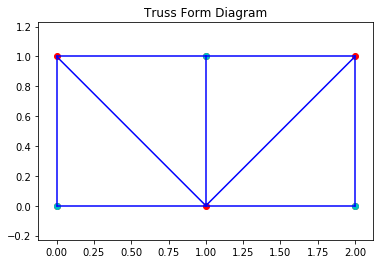

In [50]:
nodes = np.array([[0, 0], [0, 1], [1, 0], [1, 1], [2, 0], [2, 1]])
members = np.array([[0, 1], [0, 2], [1, 2], [1, 3], [2, 3], [2, 5], [3, 5], [2, 4], [4, 5]])
#nodes, members = create_Pratt(10, 4, 5)


truss = Truss(nodes, members)
truss.plot_form()

truss.forces = np.array([-1, 1/2, 1/2])
truss.force_node = np.array([3, 4, 0])
#truss.forces = np.array([-1, 1/2, 1/2])
#truss.force_node = np.array([5, 8, 0])

plt.scatter(nodes[truss.force_node, 0], nodes[truss.force_node, 1], c='c')
plt.axis('equal')
plt.title('Truss Form Diagram')

# Truss Connectivity

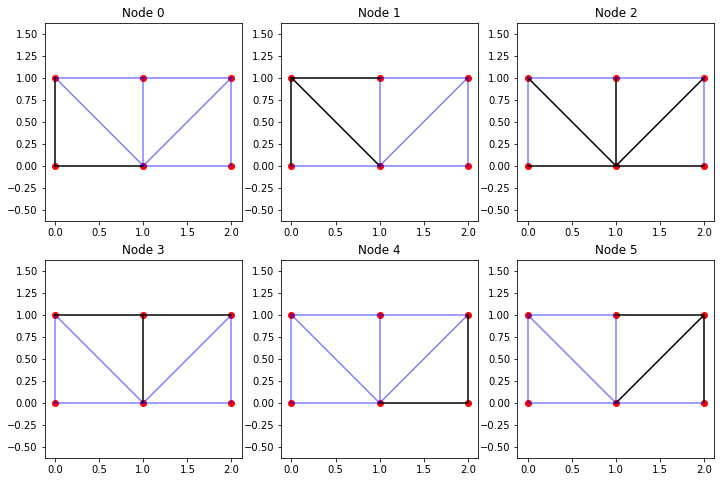

In [51]:
truss.get_connectivity()

fig, ax = plt.subplots(math.ceil(truss.nodes.shape[0]/3), 3, figsize = (12, 4*math.ceil(truss.nodes.shape[0]/3)))

for i in range(nodes.shape[0]):
    xi = math.floor(i/3)
    xj = i%3
    
    truss.plot_form(ax=ax[xi, xj], alpha=0.5, highlight_mem=truss.connectivity[i]-len(truss.forces), highlight_c='k')
    ax[xi, xj].set_title('Node '+str(i))
    ax[xi, xj].axis('equal')

In [52]:
truss.init_force_space()
truss.find_spaces()

In [53]:
# Force Space links the nodes to the force lines on it
truss.force_space

[{4: [2, 3], 3: [3, 0], 2: [0, 2]},
 {6: [4, 0], 3: [0, 3], 5: [3, 4]},
 {10: [2, 6], 8: [6, 5], 7: [5, 4], 5: [4, 3], 4: [3, 2]},
 {9: [5, 1], 0: [1, 0], 6: [0, 4], 7: [4, 5]},
 {11: [1, 6], 10: [6, 2], 1: [2, 1]},
 {9: [1, 5], 8: [5, 6], 11: [6, 1]}]

Text(0.5, 0.98, 'Force Diagrams per Node')

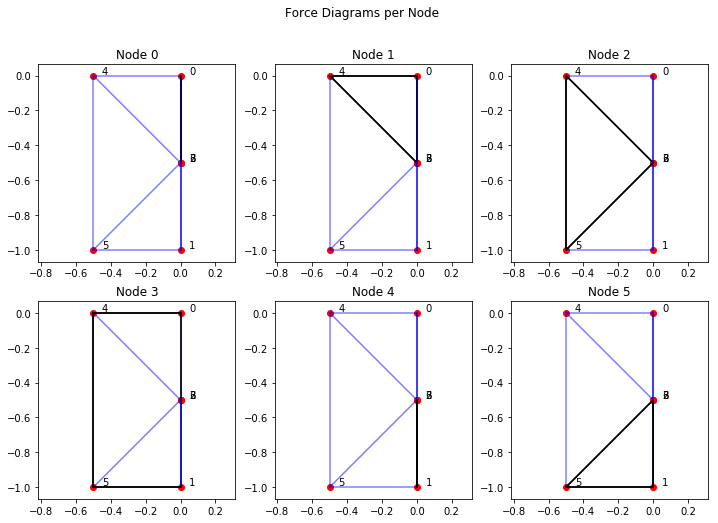

In [55]:
fig, ax = plt.subplots(math.ceil(truss.nodes.shape[0]/3), 3, figsize = (12, 4*math.ceil(truss.nodes.shape[0]/3)))

for i in range(nodes.shape[0]):
    xi = math.floor(i/3)
    xj = i%3
    
    truss.plot_force(ax=ax[xi, xj], alpha=0.5, highlight_mem=list(truss.force_space[i].keys()), highlight_c='k')
    ax[xi, xj].set_title('Node '+str(i))
    ax[xi, xj].axis('equal')
fig.suptitle('Force Diagrams per Node')